In [1]:
import matplotlib.pyplot as plt
import cv2
import os,glob
import numpy as np


In [2]:
def show_images(images,cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10,11))#figsize 指定宽和高，单位是英寸
    for i ,image in enumerate(images):
        plt.subplot(rows,cols,i+1)
        #use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image,cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0,h_pad=0,w_pad=0)
    plt.show()

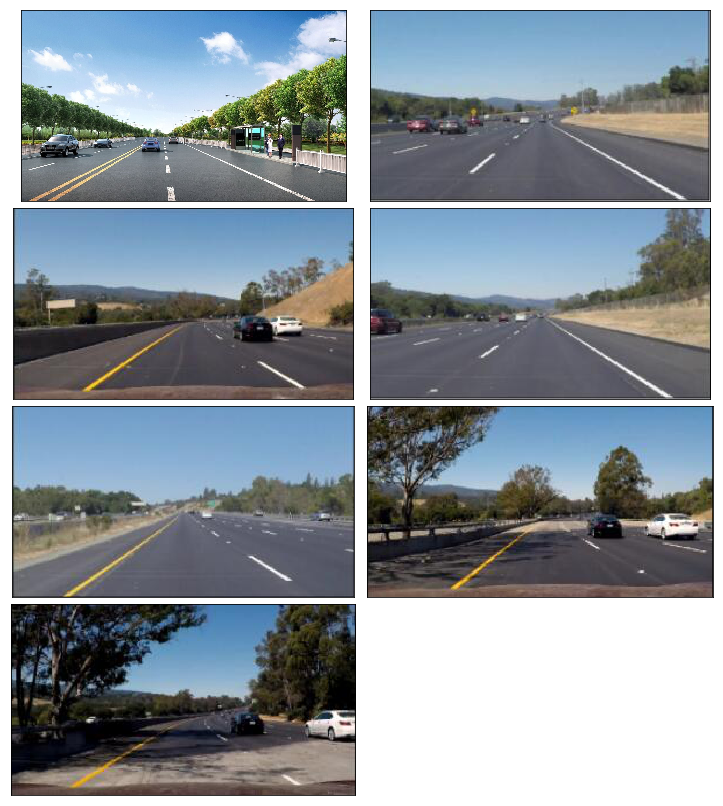

In [3]:
test_images = [plt.imread(path) for path in glob.glob('road/*.jpg')]
show_images(test_images)

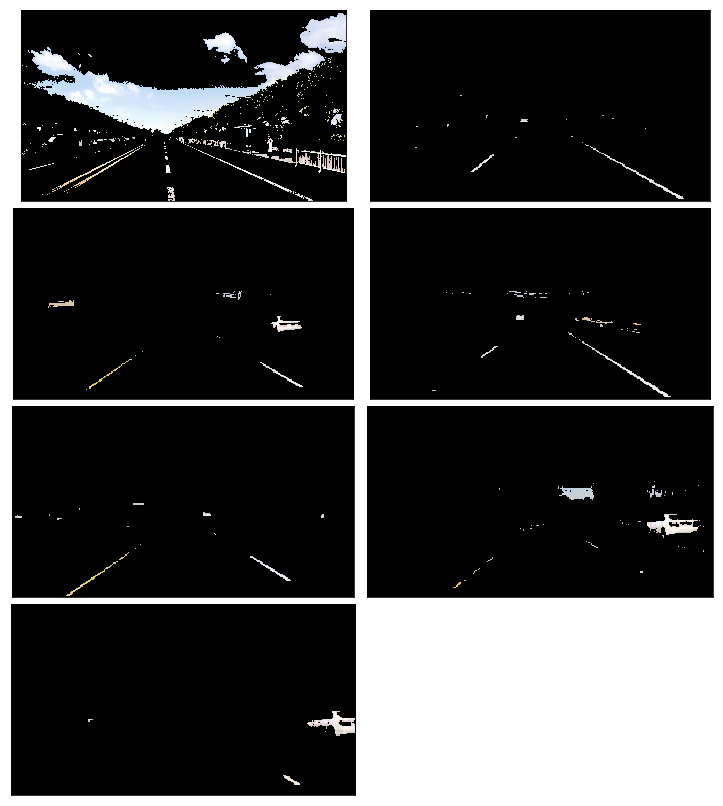

In [4]:
#image is expected be in RGB color space 

def select_rgb_white_yellow(image):
    lower = np.uint8([200,200,200])
    upper = np.uint8([255,255,255])
    white_mask = cv2.inRange(image,lower,upper)
    #yellow color mask
    lower = np.uint8([190,190,0])
    upper = np.uint8([255,255,255])
    yello_mask = cv2.inRange(image,lower,upper)#可实现二值化功能类似threshold()函数
    #combine the mask
    mask = cv2.bitwise_or(white_mask,yello_mask)
    masked = cv2.bitwise_and(image,image,mask=mask)
    return masked
show_images(list(map(select_rgb_white_yellow,test_images)))

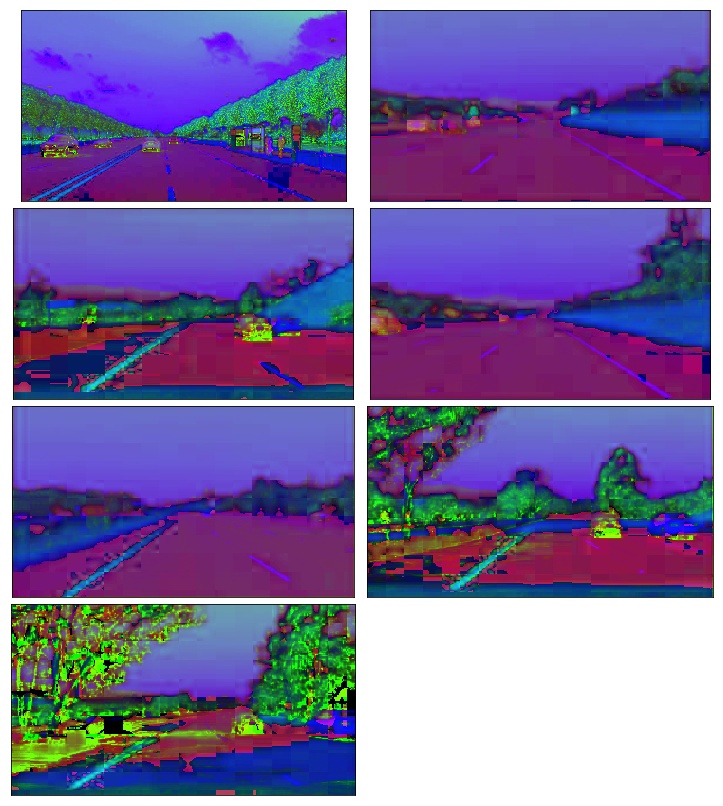

In [5]:
# HSV Color space
def convert_hsv(image):
    return cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
show_images(list(map(convert_hsv,test_images)))

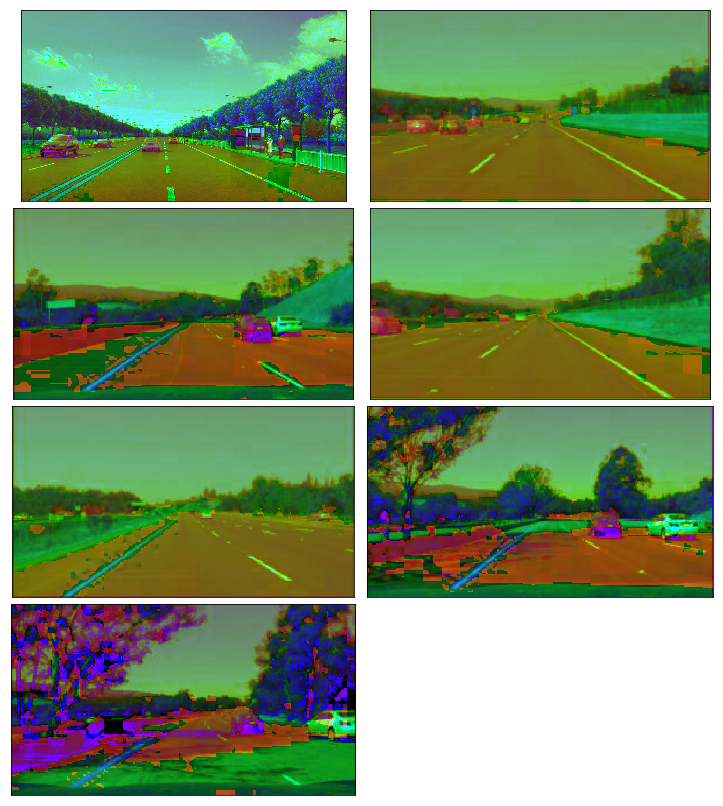

In [6]:
#HSL color space
def convert_hls(image):
    return cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
show_images(list(map(convert_hls,test_images)))

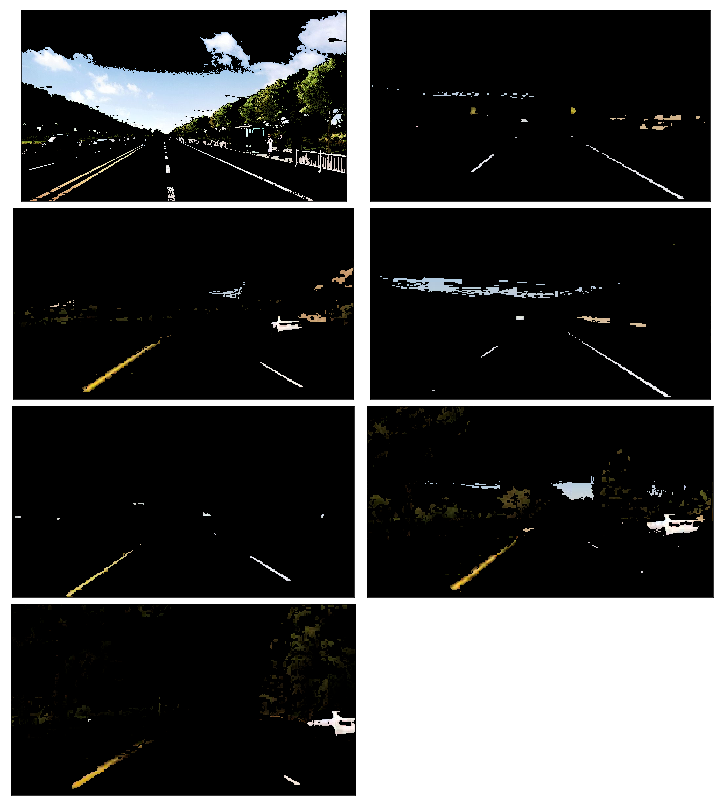

In [7]:
def select_white_yellow(image):
    converted = convert_hls(image)
    #white color mask
    lower = np.uint8([0,200,0])
    upper = np.uint8([255,255,255])
    white_mask = cv2.inRange(converted,lower,upper)
    #yellow color mask
    lower = np.uint8([10,0,100])
    upper = np.uint8([40,255,255])
    yellow_mask = cv2.inRange(converted,lower,upper)
    #combine the mask
    mask = cv2.bitwise_or(white_mask,yellow_mask)
    return cv2.bitwise_and(image,image,mask=mask)
white_yellow_images = list(map(select_white_yellow,test_images))
show_images(white_yellow_images)

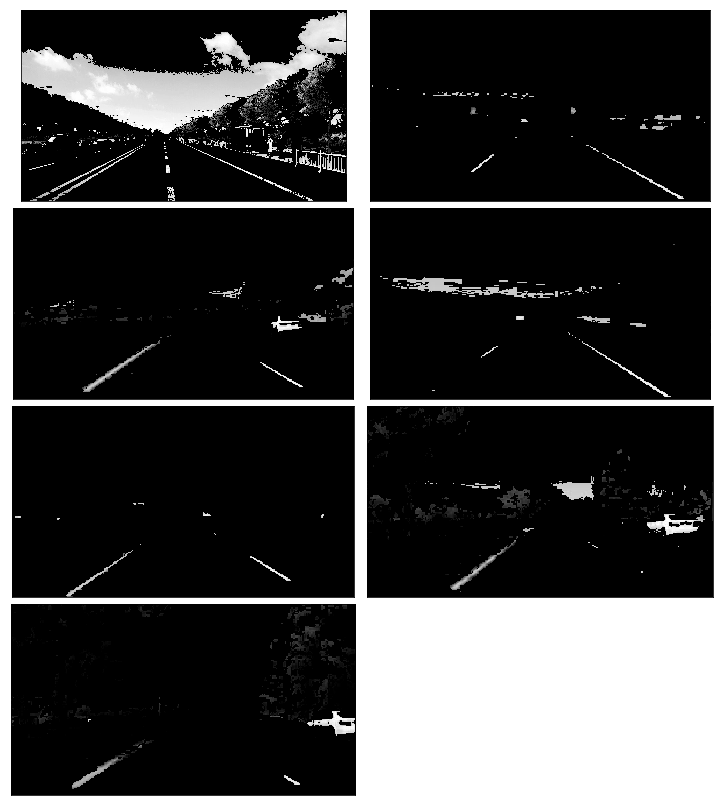

In [8]:
def convert_gray_scale(image):
    return cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
gray_images = list(map(convert_gray_scale,white_yellow_images))
show_images(gray_images)

In [9]:
def apply_smooting(image,kernel_size = 5):
    #kernel size must be postive and odd
    return cv2.GaussianBlur(image,(kernel_size,kernel_size),0)

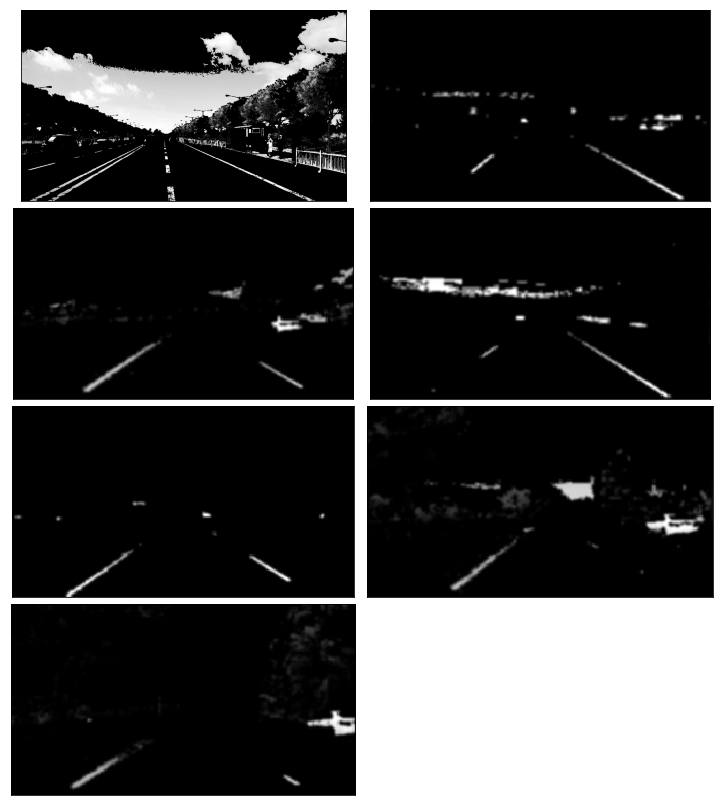

In [10]:
blurred_images = list(map(lambda image: apply_smooting(image),gray_images))
show_images(blurred_images)

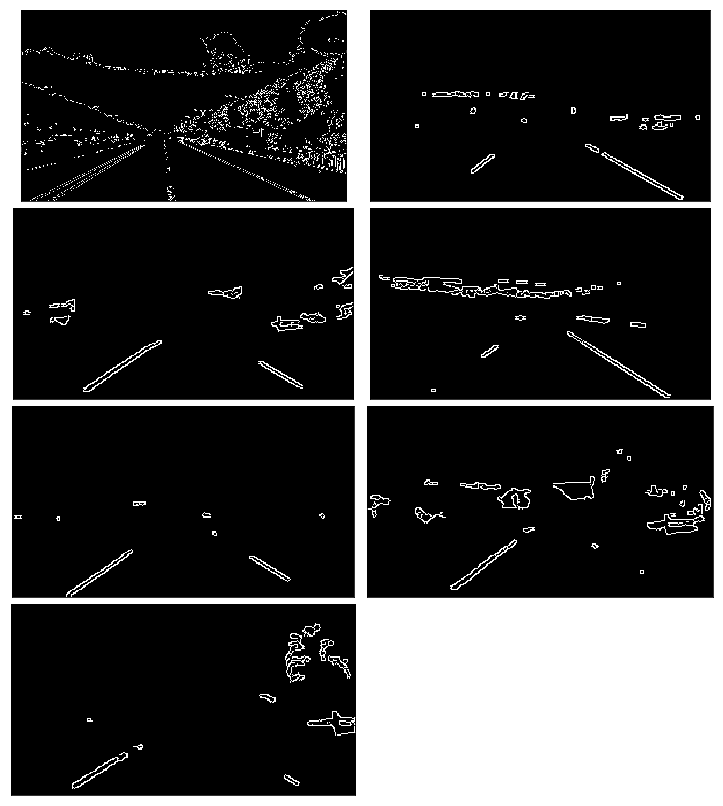

In [11]:
def detect_edges(image,low_threshold=0,high_threshold=150):
    return cv2.Canny(image,low_threshold,high_threshold)
edge_images = list(map(lambda image: detect_edges(image),blurred_images))
show_images(edge_images)

In [40]:
def filter_region(image,vertices):
#     create the mask using the vertices and apply it to the input image
     mask = np.zeros_like(image)
     if len(mask.shape)==2:
        cv2.fillPoly(mask,vertices,255)
     else:
        cv2.fillPoly(mask,vertices,(255)*mask.shape[2])
     return cv2.bitwise_and(image,mask)

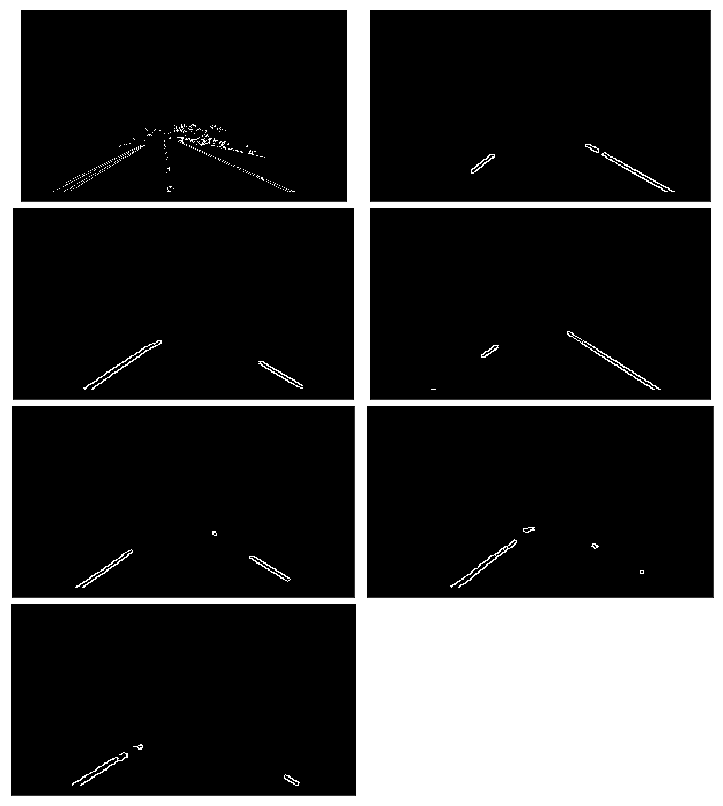

In [41]:
def select_region(image):
#     ite keeps the region surrounded by the vertices .other area is et to 0
#     first ,define the polygon by vertices
    rows,cols = image.shape[:2]
    bottom_left = [cols*0.1,rows*0.95]
    top_left = [cols*0.4,rows*0.6]
    bottom_right = [cols*0.9,rows*0.95]
    top_rigth = [cols*0.6,rows*0.6]
    vertices = np.array([[bottom_left,top_left,top_rigth,bottom_right]],dtype=np.int32)
    return filter_region(image,vertices)

roi_images = list(map(select_region,edge_images))
show_images(roi_images)

In [42]:
def hough_lines(image):
    return cv2.HoughLinesP(image,rho=1,theta=np.pi/180,threshold=20,minLineLength=20,maxLineGap=300)

list_of_lines = list(map(hough_lines,roi_images))

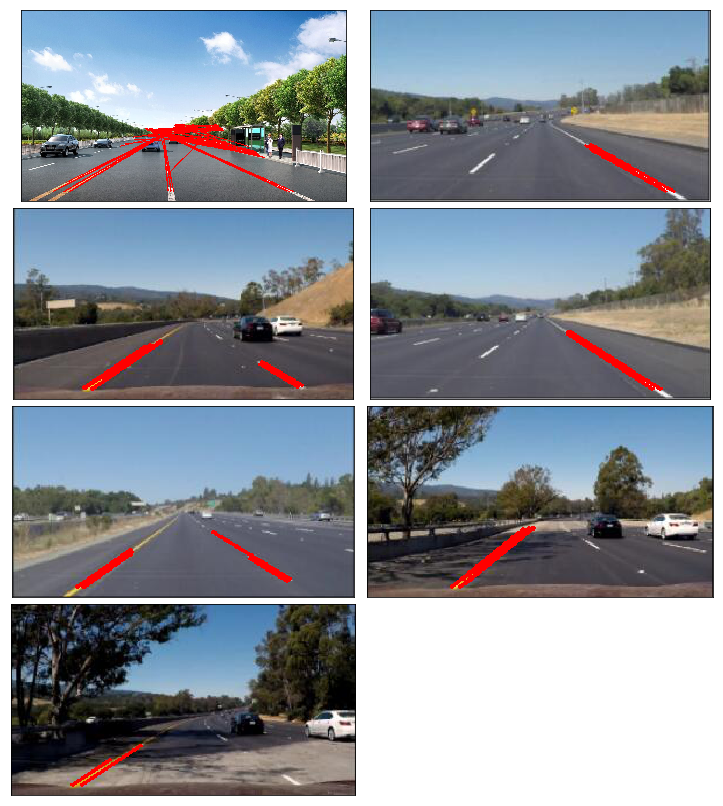

In [44]:
def draw_lines(image,lines,color=[255,0,0],thickness=2,make_copy=True):
    if make_copy:
        image = np.copy(image)#don't want to modify the original
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image,(x1,y1),(x2,y2),color,thickness)
    return image

line_iamges=[]
for image,lines in zip(test_images,list_of_lines):
    line_iamges.append(draw_lines(image,lines))
show_images(line_iamges)

In [45]:
def average_slope_intercept(lines):
    left_lines =[]
    left_widghts = []
    right_lines=[]
    right_weights=[]
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x2==x1:
                continue
            slope =(y2-y1)/(x2-x1)
            intercept = y1-slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope<0:
                left_lines.append((slope,intercept))
                left_widghts.append((length))
            else:
                right_lines.append((slope,intercept))
                right_weights.append((length))
#         add more weight to longer lines
    left_lane = np.dot(left_widghts,left_lines)/np.sum(left_widghts) if len(left_widghts)>0 else None
    right_lane = np.dot(right_weights,right_lines)/np.sum(right_weights) if len(right_weights)>0 else None

    return left_lane,right_lane

In [49]:
def make_line_points(y1,y2,line):
    if line is None:
        return None
    slope,intercept = line
    
    x1 = int((y1-intercept)/slope)
    x2 = int((y2-intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1,y1),(x2,y2))

In [55]:
def lane_lines(image,lines):
    left_lane,right_lane = average_slope_intercept(lines)
    y1 = image.shape[0]
    y2 = y1*0.6
    
    left_line = make_line_points(y1,y2,left_lane)
    right_line = make_line_points(y1,y2,right_lane)
    
    return left_line,right_line

def draw_lane_lines(image,lines,color=[255,0,0],thickness=5):
    line_image=np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image,*line,color,thickness)
    return cv2.addWeighted(image,1.0,line_image,0.95,0.0)

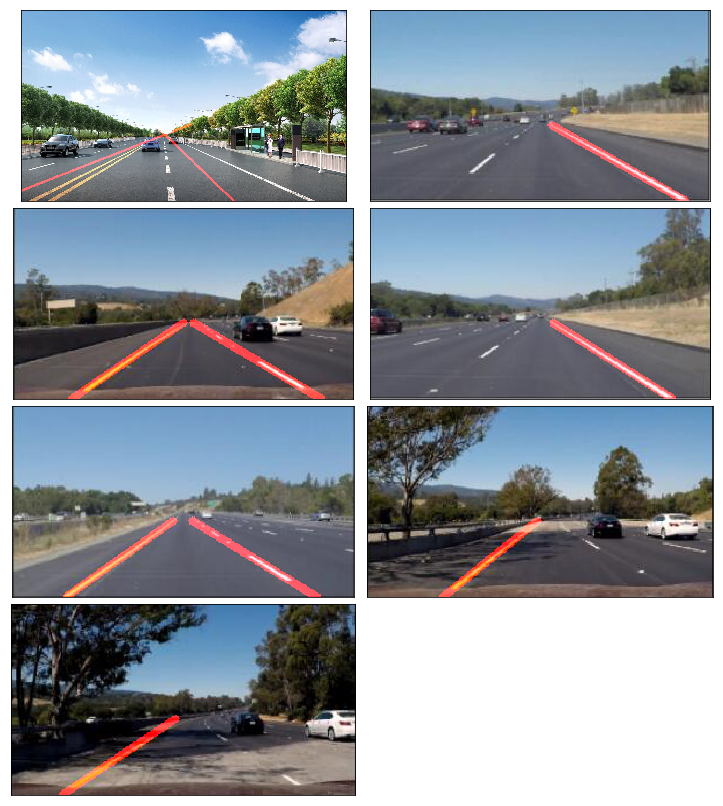

In [57]:
lane_images = []
for image,lines in zip(test_images,list_of_lines):
    lane_images.append(draw_lane_lines(image,lane_lines(image,lines)))
    
show_images(lane_images)